Topic model

In [2]:
%%capture
!pip install transformers

In [3]:
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [ ]:
with open('proj_1_submissions.pkl','rb') as f:
  subs = pickle.load(f)
# subs = subs[['topic', 'selftext']]
with open('proj_1_comments.pkl','rb') as f:
  coms = pickle.load(f)
# coms = coms[['topic', 'selftext']]

In [ ]:
subs = subs.dropna(subset=['topic'])
t3_coms = coms[coms['parent_id'].astype(str).str[0:2] == 't3']
t3_coms['parent_id'] = t3_coms['parent_id'].astype(str).str[3:]
t1_coms = coms[coms['parent_id'].astype(str).str[0:2] == 't1']
t1_coms['parent_id'] = t1_coms['parent_id'].astype(str).str[3:]

<ipython-input-116-70a714394de9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t3_coms['parent_id'] = t3_coms['parent_id'].astype(str).str[3:]
<ipython-input-116-70a714394de9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1_coms['parent_id'] = t1_coms['parent_id'].astype(str).str[3:]


In [ ]:
t3_coms = pd.merge(t3_coms[['id','parent_id','body']], subs[['id', 'topic']], left_on='parent_id', right_on='id', how='inner')[['topic','body']]
t3_coms.rename(columns={"body": "selftext"}, inplace=True)
t3_coms.head()

,topic,selftext
0,Politics,&gt;It is illegal for states to secede in the ...
1,Politics,&gt;The true threat of China is her propensity...
2,Healthcare,Are all humiliation fetishes mental illnesses?...
3,Healthcare,You can literally make any fetish sound bad if...
4,Healthcare,But on what grounds are you considering it a m...


In [ ]:
subs = subs[['topic', 'selftext']]

In [ ]:
a = [subs, t3_coms]

model_data = pd.concat(a)

In [ ]:
model_data.head()

,topic,selftext
0,Politics,So just now we got leaks courtesy of Mia and D...
1,Politics,Can anyone tell me any testimony how they turn...
2,Politics,I have quite been active in social media seein...
3,Politics,We did it everyone! Because of stores not chec...
4,Politics,So thats a blanket statement for most of us to...


In [22]:
model_data.shape

(18969, 2)

In [ ]:
model_data.to_csv('bert_model_data.csv', index=False)

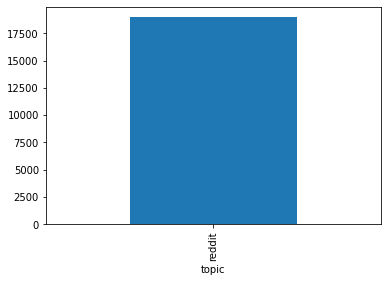

In [25]:
model_data['topic'] = 'reddit'
model_data.groupby(['topic']).size().plot.bar()

In [ ]:
# model_data = pd.read_csv('bert_model_data.csv')

In [26]:
with open('chitchat.pkl','rb') as f:
  ch = pickle.load(f)
type(ch)

pandas.core.frame.DataFrame

In [27]:
ch['topic'] = 'chitchat'
ch.rename(columns = {'sender':'selftext'}, inplace=True)
ch[0:19000][['topic', 'selftext']].shape

(19000, 2)

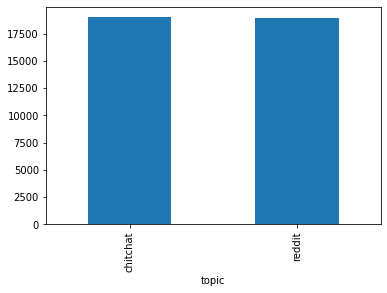

In [29]:
model_data_cc = pd.concat([model_data, ch[0:19000][['topic', 'selftext']]])
model_data_cc.groupby(['topic']).size().plot.bar()

In [30]:
model_data_cc.to_csv('bert_model_data_cc_binary.csv', index = False)

In [4]:
# model_data_cc = pd.read_csv('bert_model_data_cc.csv')

In [31]:
# Preprocessing
import string

def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
model_data_cc['selftext']= model_data_cc['selftext'].apply(lambda x:remove_punctuation(x))
model_data_cc.head()

model_data_cc['selftext']= model_data_cc['selftext'].apply(lambda x: x.lower())
model_data_cc['topic']= model_data_cc['topic'].apply(lambda x: x.lower())

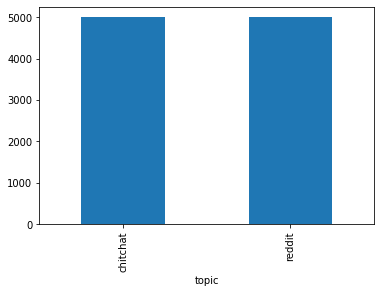

In [32]:
model_data_cc = model_data_cc.sample(10000, random_state=59)
model_data_cc.groupby(['topic']).size().plot.bar()

In [33]:
model_data_cc.head()

,topic,selftext
579,reddit,like most people i use alternate start usually...
9884,chitchat,haha thats pretty funny i feel like everyone t...
14831,chitchat,oooh thats a good one someone who does not bre...
1322,chitchat,probably spanish i am hispanic but i dont spea...
8192,reddit,the quickest way to get what you want is\nvari...


BERT Preprocessing

In [53]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'reddit':0,
          'chitchat':1
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['topic']]
        self.texts = [tokenizer(text,
                                padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['selftext']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [40]:
np.random.seed(123)
df_train, df_val, df_test = np.split(model_data_cc.sample(frac=1, random_state=42), 
                                     [int(.8*len(model_data_cc)), int(.9*len(model_data_cc))])

print(len(df_train),len(df_val), len(df_test))

8000 1000 1000


Model building

In [54]:
from torch import nn
from transformers import BertModel
from transformers import BertForSequenceClassification

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

Model training

In [49]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    # train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                                
# train(model, df_train, df_val, LR, EPOCHS)

In [47]:
train_set, val_set = Dataset(df_train), Dataset(df_val)

In [52]:
# Model config
EPOCHS = 10
model = BertClassifier()
LR = 1e-6

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [51]:
%%time
train(model, train_set, val_set, LR, EPOCHS)
# model.fit(x_train, y_train)

100%|██████████| 4000/4000 [14:36<00:00,  4.57it/s]


Epochs: 1 | Train Loss:  0.286                 | Train Accuracy:  0.553                 | Val Loss:  0.240                 | Val Accuracy:  0.724


100%|██████████| 4000/4000 [14:45<00:00,  4.52it/s]


Epochs: 2 | Train Loss:  0.176                 | Train Accuracy:  0.845                 | Val Loss:  0.153                 | Val Accuracy:  0.877


100%|██████████| 4000/4000 [14:45<00:00,  4.52it/s]


Epochs: 3 | Train Loss:  0.125                 | Train Accuracy:  0.896                 | Val Loss:  0.142                 | Val Accuracy:  0.889


100%|██████████| 4000/4000 [14:45<00:00,  4.52it/s]


Epochs: 4 | Train Loss:  0.086                 | Train Accuracy:  0.940                 | Val Loss:  0.140                 | Val Accuracy:  0.895


100%|██████████| 4000/4000 [14:45<00:00,  4.52it/s]


Epochs: 5 | Train Loss:  0.053                 | Train Accuracy:  0.965                 | Val Loss:  0.161                 | Val Accuracy:  0.898


100%|██████████| 4000/4000 [14:46<00:00,  4.51it/s]


Epochs: 6 | Train Loss:  0.034                 | Train Accuracy:  0.981                 | Val Loss:  0.189                 | Val Accuracy:  0.890


100%|██████████| 4000/4000 [14:46<00:00,  4.51it/s]


Epochs: 7 | Train Loss:  0.026                 | Train Accuracy:  0.985                 | Val Loss:  0.205                 | Val Accuracy:  0.893


100%|██████████| 4000/4000 [14:45<00:00,  4.52it/s]


Epochs: 8 | Train Loss:  0.020                 | Train Accuracy:  0.987                 | Val Loss:  0.202                 | Val Accuracy:  0.892


100%|██████████| 4000/4000 [14:46<00:00,  4.51it/s]


Epochs: 9 | Train Loss:  0.015                 | Train Accuracy:  0.991                 | Val Loss:  0.242                 | Val Accuracy:  0.885


100%|██████████| 4000/4000 [14:45<00:00,  4.52it/s]


Epochs: 10 | Train Loss:  0.011                 | Train Accuracy:  0.992                 | Val Loss:  0.255                 | Val Accuracy:  0.879
CPU times: user 1h 52min 23s, sys: 41min 34s, total: 2h 33min 57s
Wall time: 2h 34min 2s


In [57]:
torch.save(model.state_dict(), './binary_bert_model.pt')


Model evaluate

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [ ]:
evaluate(model, df_test)

In [ ]:
example_query = 'Hi how are you?'
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
texts = tokenizer(example_query, 
                  padding='max_length', max_length = 512, truncation=True,
                  return_tensors="pt")
mask = texts['attention_mask'].to(device)
input_id = texts['input_ids'].squeeze(1).to(device)

output = model(input_id, mask)
print(torch.max(output))
print(list(labels.keys())[(torch.argmax(output).item())])
print(output)